# A Niave GA to solve the MKP 
**Written by Dr Bruce Cox** </br>
**Last modified:** 22 Sept 2021 </br>

This code very roughly follows the outline found here: http://www.micsymposium.org/mics_2004/Hristake.pdf


## 0. Import Libraries and Data

In [81]:
import pandas as pd
import random
import numpy as np
import array
import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
mkp_data = pd.read_excel("MKP_Data.xlsx", index_col=None)
mkp_array = mkp_data.to_numpy()
print(mkp_array.shape)
#print(mkp_array)

(200, 3)


## 1. Set Constraints and GA Tunable Paramaters

### Problem Parameters

In [83]:
max_weight = 55
max_volume = 4000

### Tuneable Parameters
#### <span style="color: red;">You probably want to change population size and mutation rates...</span>.

In [84]:
popsize = 20 
mutate_odds = .3
generations = 50000

## 2. Create Helper Functions

### Create a function that calculates solution value, weight and volume

In [85]:
def calculator(chromosome):
    value = np.dot(chromosome, mkp_array[:,0])
    weight = np.dot(chromosome, mkp_array[:,1])
    volume = np.dot(chromosome, mkp_array[:,2])
    
    return value, weight, volume

### Create a function that checks for and fixes infeasibility
#### <span style="color: red;">This is one area you should seriously consider changing</span>.

In [86]:
def fixer(chromosome):
    _, weight, volume = calculator(chromosome)
    infeasible = True

    while infeasible:
        # Drop items until feasibility is achieved
        infeasible =  False

        slack_v = max_volume - volume
        slack_w = max_weight - weight

        # Check constraints
        if slack_w <= 0 or slack_v <= 0: 
            infeasible = True

            # If weight is more violated than volume
            if slack_w < slack_v:
                # Drop with largest weight to value ratio
                i = np.argmax(chromosome * mkp_array[:,1] / mkp_array[:,0])
                chromosome[i]=0
            else:
                # Drop item with worst voluminous to value ratio
                i = np.argmax(chromosome * mkp_array[:,2]/ mkp_array[:,0])
                chromosome[i]=0

        _, weight, volume = calculator(chromosome)

    # End infeasibility loop

    # Check if any items can fit in the bag
    slack_v = max_volume - volume
    slack_w = max_weight - weight
    eligible_items = [mkp_array[i,1] <= slack_w and mkp_array[i,2] <= slack_v and not chromosome[i] for i in range(len(mkp_data))]

    while np.sum(eligible_items) > 0:
        # Find the most valuable of the items that can fit and add it
        if slack_w < slack_v:
            new_item = np.argmax(eligible_items * mkp_array[:,0] / mkp_array[:,1])
            chromosome[new_item] = 1
        else:
            new_item = np.argmax(eligible_items * mkp_array[:,0] / mkp_array[:,2])
            chromosome[new_item] = 1

        # Re-calculate until no items can fit
        _, weight, volume = calculator(chromosome)
        slack_v = max_volume - volume
        slack_w = max_weight - weight
        eligible_items = [mkp_array[i,1] <= slack_w and mkp_array[i,2] <= slack_v and not chromosome[i] for i in range(len(mkp_data))]

    return chromosome

### Create a function that selects 2 parents and creates a child
#### <span style="color: red;">You should definetly change this section.  How else could you choose parents?  How else could you update population?  Look at class notes for ideas!</span>.

In [87]:
def next_gen(population):
    pop_value=[]
    for i in range(0,popsize):   #calculate value for all members of population and save it into list pop_value
        value, weight, volume = calculator(population[i,:])
        temp = np.append(pop_value, [value], axis=0)
        pop_value = temp
        
    ndx = np.argsort(-pop_value)  #sort indexes of pop_value from largest to smallest
    mom, dad = np.random.randint(low=0, high=round(popsize/4), size=2)  #select two random numbers from 0 to 1/4 population size. These two numbers are the index of two parents
    #crossover = np.random.randint(low=0, high=len(mkp_array[:,0]), size=1)  #randomly select a crossover locus in middle 1/3 of genes
    crossover = np.random.randint(low=len(mkp_array[:,0])*1/3, high=len(mkp_array[:,0])*2/3, size=1)  #randomly select a crossover locus in middle 1/3 of genes
    child=np.append(population[ndx[mom],:(crossover[0])], population[ndx[dad],crossover[0]:])    #take "left half" of mom and "right half" of Dad as child
    
    return child, pop_value, ndx

### Create a function that mutates a chromosome 

In [88]:
def mutate(chromosome):
    for i in range(0,len(mkp_data)):
        if random.uniform(0, 1) <= mutate_odds:
            if chromosome[i] == 1: 
                chromosome[i] = 0 
            if chromosome[i] == 0: 
                chromosome[i] = 1
    return chromosome

## 3. Execute GA

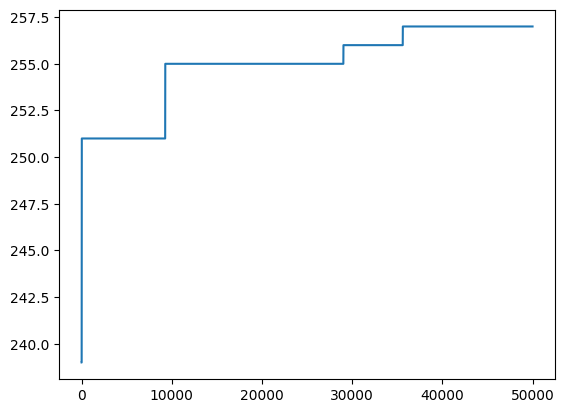

In [89]:
x_data_plot=[]
y_data_plot=[]
pop_value = [0]

#Create random population
population = np.random.randint(low=0, high=2, size=(popsize,len(mkp_data)))

#Ensure feasibility of initial random population
for i in range(0, popsize):
    population[i] = fixer(population[i])

#Run GA for generations
for i in range(0, generations):
    child, pop_value, ndx = next_gen(population)
    child = mutate(child)
    child = fixer(child)
    value, weight, volume = calculator(child)
    if value > pop_value[ndx[popsize-1]]:
        population[ndx[popsize-1]] = child
    x_data_plot.append(i)
    y_data_plot.append(max(pop_value))

plt.plot(x_data_plot,y_data_plot)
plt.show()